### Import Libraries

In [1]:
# data visualisation
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates
from mpl_toolkits.mplot3d import Axes3D

# data processing 
import pandas as pd
# Linear algebra
import numpy as np

# algorithms
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from itertools import cycle,islice 
import datetime as dt

In [2]:
# Getting the Data
Data = pd.read_excel('./Online Retail.xlsx')
Data.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Data Exploration

In [3]:
Initial= Data.shape
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
Data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
 Data.duplicated().sum()

5268

From the above information we can note a few things. Firstly, the columns are all already in the correct formats respectively, so I will not need to convert them.  

The data however needs a little cleaning. There are at least 135080 missing rows 5268 duplicated rows. I will therefore go ahead and drop those.

In [6]:
# drop rows with missing values and duplicated rows
Data = Data.dropna()
Data = Data.drop_duplicates()
After=Data.shape
After



(401604, 8)

In [7]:
dropped= Initial[0]-After[0]
print('We dropped a total of {} rows'.format(dropped))
print('Which is {}% of our total Dataset'.format(round(100*(dropped/Initial[0])),2))

We dropped a total of 140305 rows
Which is 26% of our total Dataset


26% is quite a sizeable chunk of the data to be lost, however, we are left with 401604 rows. As a sample size, this is more than enough to model the data with and derive patterns of customer behaviour which are descriptive of the retail stores customer base as a whole. 

In [8]:
# checking for null or duplicated values in data
Data.isnull().sum().any(), Data.duplicated().sum().any()


(False, False)

Now that the Data has been sufficiently cleaned and there are no null or duplicated values, I will proceed with data visualisation to try to derive insights from the data.

C:\Users\Joseph\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:203: UserWarning: When passing multiple axes, layout keyword is ignored
  "ignored", UserWarning)


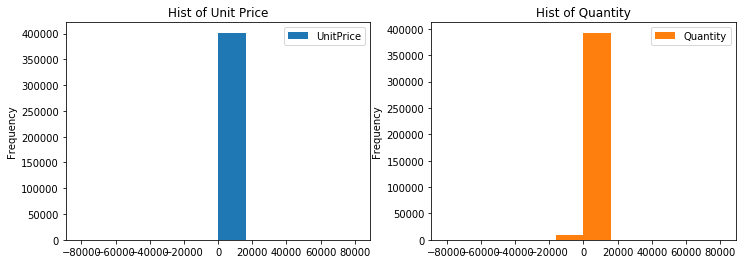

In [9]:
fig, ax = plt.subplots(1,2, figsize = (12,4))
Data[['UnitPrice', 'Quantity']].plot(kind = 'hist', figsize =(12,4), subplots=True, sharex=False, layout =(1,2), ax = ax)
ax[1].set_title('Hist of Quantity')
ax[0].set_title('Hist of Unit Price')
plt.show()

As can be seen from the histogram of quantity and unit price some values have are less than 0. It is not possible to buy less than 1 item unless factoring in for returns. I will therefore also be removing these items

In [10]:
# working out the percentage of data that will be filtered out
len(Data[Data['Quantity']<0])/After[0], len(Data[Data['UnitPrice']<0])/After[0]

(0.02209141343213713, 0.0)

In [11]:
Data = Data[Data['Quantity']>0]
Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392732 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      392732 non-null object
StockCode      392732 non-null object
Description    392732 non-null object
Quantity       392732 non-null int64
InvoiceDate    392732 non-null datetime64[ns]
UnitPrice      392732 non-null float64
CustomerID     392732 non-null float64
Country        392732 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.0+ MB


### Data Visualisation

From the visualisation I would like to find out some characteristics of the sales being made. The aim of this project is to segment customers for targeted marketing. Therefore, it would also be helpful to have some information on the success of products to select candidates to push for marketing.

Firstly I would like to know what the best selling and therefore most popular item is.

In [12]:
# Number of unique descriptions
Data['Description'].nunique()

3877

In [13]:
Most_Pop = Data['Description'].value_counts()[:20]
Most_Pop 

WHITE HANGING HEART T-LIGHT HOLDER    2016
REGENCY CAKESTAND 3 TIER              1714
JUMBO BAG RED RETROSPOT               1615
ASSORTED COLOUR BIRD ORNAMENT         1395
PARTY BUNTING                         1390
LUNCH BAG RED RETROSPOT               1303
SET OF 3 CAKE TINS PANTRY DESIGN      1152
POSTAGE                               1099
LUNCH BAG  BLACK SKULL.               1078
PACK OF 72 RETROSPOT CAKE CASES       1050
SPOTTY BUNTING                        1014
PAPER CHAIN KIT 50'S CHRISTMAS        1003
LUNCH BAG SPACEBOY DESIGN              993
HEART OF WICKER SMALL                  979
LUNCH BAG CARS BLUE                    977
NATURAL SLATE HEART CHALKBOARD         972
LUNCH BAG PINK POLKADOT                941
LUNCH BAG SUKI DESIGN                  915
REX CASH+CARRY JUMBO SHOPPER           897
ALARM CLOCK BAKELIKE RED               886
Name: Description, dtype: int64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

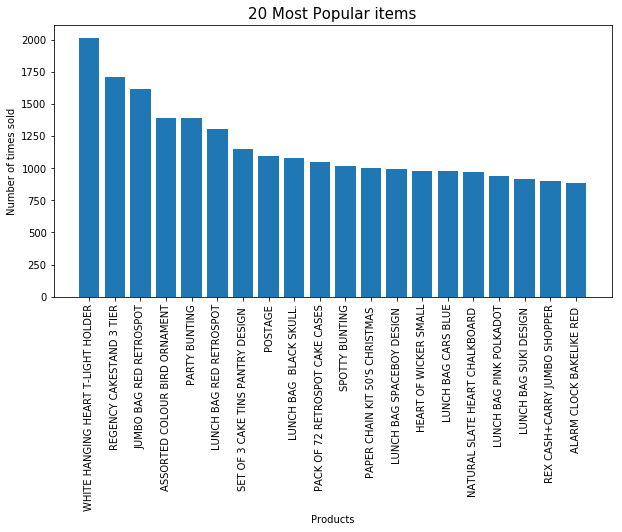

In [14]:
Most_Pop = pd.DataFrame(Most_Pop)
fig, ax = plt.subplots(figsize=(10,5))
plt.bar(Most_Pop.index, Most_Pop['Description'])
ax.set_title('20 Most Popular items', fontsize = 15)
ax.set_ylabel('Number of times sold')
ax.set_xlabel('Products')
plt.xticks(rotation=90)

The above graph shows us the most popular products. While this is useful, it would also be beneficial to calculate the most valuable products. To do so I will compute the sum of the Total Price of the each item, per item. The most valuable product will be considered that which brings in the most revenue.

In [15]:
# creating a new column for the total price
Data['TotalPrice'] = Data['UnitPrice'] * Data['Quantity']

In [16]:
# grouping the Data by Description and suming the Total price for each item
Value = Data.groupby('Description')[['Description','TotalPrice']].sum().sort_values(by ='TotalPrice', ascending=False)[:15]
Value.rename(columns={'TotalPrice': 'Value'}, inplace = True)
Value

,Value
Description,
"PAPER CRAFT , LITTLE BIRDIE",168469.60
REGENCY CAKESTAND 3 TIER,142264.75
WHITE HANGING HEART T-LIGHT HOLDER,100392.10
JUMBO BAG RED RETROSPOT,85040.54
MEDIUM CERAMIC TOP STORAGE JAR,81416.73
POSTAGE,77803.96
PARTY BUNTING,68785.23
ASSORTED COLOUR BIRD ORNAMENT,56413.03
Manual,53419.93


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text xticklabel objects>)

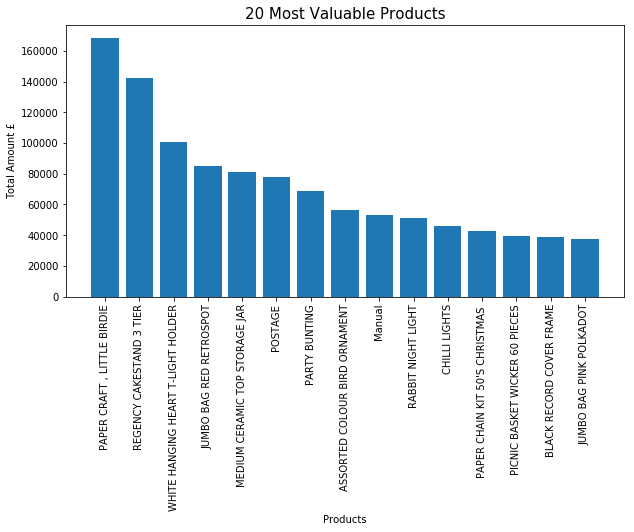

In [17]:
fig, ax = plt.subplots(figsize=(10,5))
plt.bar(Value.index, Value['Value'])
ax.set_title('20 Most Valuable Products', fontsize = 15)
ax.set_ylabel('Total Amount £')
ax.set_xlabel('Products')
plt.xticks(rotation=90)

Next I will be visualising the sales throughtout the year in order to derive the busiest period of the year.

In [18]:
Data['InvoiceDate'].max(), Data['InvoiceDate'].min()

(Timestamp('2011-12-09 12:50:00'), Timestamp('2010-12-01 08:26:00'))

In [19]:
# Extracting the month from the date
Data['Month'] = Data['InvoiceDate'].dt.month

Data['Month'] =Data['Month'].astype(int)
Data['Month'].unique()

array([12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64)

In [20]:
# Mapping our dictionary 'Months' which converts numbers to their respective months, over the data 
Months ={1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}
data =[Data]

for dataset in data:
    dataset['Month'] = dataset['Month'].map(Months)
    
Data['Month'].unique()
    

array(['December', 'January', 'February', 'March', 'April', 'May', 'June',
       'July', 'August', 'September', 'October', 'November'], dtype=object)

In [21]:
# grouping the data by each month and summing the revenue brought in that month
group_month= round(Data[['Month', 'TotalPrice']].groupby('Month').sum(),2)

#reindexing the dataframe so the months are in order
group_month = group_month.reindex(['January', 'February', 'March', 'April', 'May', 'June',
       'July', 'August', 'September', 'October', 'November', 'December'])
group_month= group_month.reset_index()
group_month

,Month,TotalPrice
0,January,568101.31
1,February,446084.92
2,March,594081.76
3,April,468374.33
4,May,677355.15
5,June,660046.05
6,July,598962.90
7,August,644051.04
8,September,950690.20
9,October,1035642.45


Text(0.5, 1.0, 'from december 2010 - december 2011')

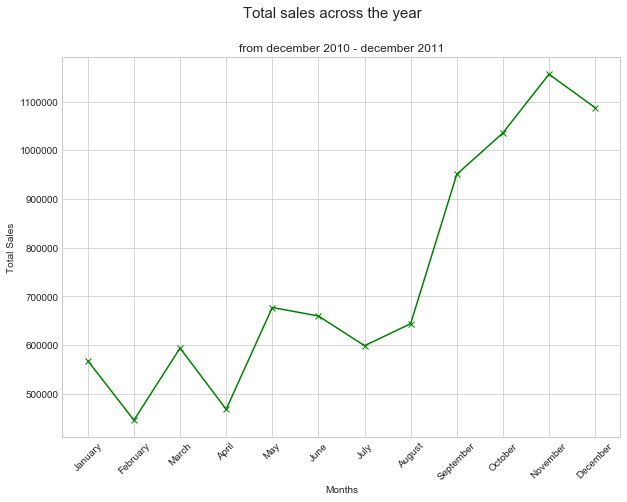

In [55]:
fig, ax = plt.subplots(figsize=(10,7))
plt.style.use('seaborn-whitegrid')
plt.plot(group_month['Month'], group_month['TotalPrice'], marker = 'x', color='g')
plt.xticks(rotation=45)
plt.xlabel('Months')
plt.ylabel('Total Sales')
plt.suptitle('Total sales across the year', fontsize = 15)
plt.title('from december 2010 - december 2011')

For this online retail company, the period where most of the sales are made begins in august and peaks in November. This would be an especially good time to push some of the more earlier identified valuable items  

In [23]:
top = Data['Country'].value_counts()[:15]
df = pd.DataFrame(top)
df

,Country
United Kingdom,349227
Germany,9027
France,8327
EIRE,7228
Spain,2480
Netherlands,2363
Belgium,2031
Switzerland,1842
Portugal,1453
Australia,1184


Text(0, 0.5, 'Number of Sales')

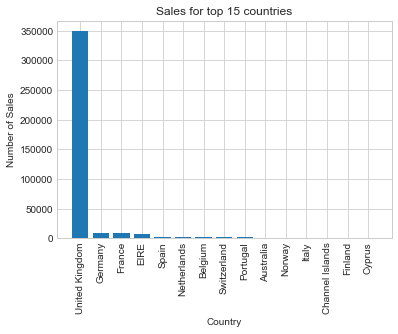

In [24]:
fig, ax = plt.subplots()
plt.bar(df.index, df['Country'])
plt.xticks(rotation=90)
ax.set_title('Sales for top 15 countries')
ax.set_xlabel('Country')
ax.set_ylabel('Number of Sales')

Most of this company's sales are focused in the UK as seen in the above graph. If considering building a store, it would appear that the UK would provide the best option for such. It would have been of further interest to assess the most popular items in different countries. However, as the sales in the UK are vastly higher than all other countries, this analysis would be negligable. 

### Data Preprocessing

As part of the preprocessing process I will be creating the columns necessary for the RFM analysis. 

I will start with the recency column. To see how recent the customer purchases are I will assume this analysis is being carried out the day after the most recent purchase and use this as reference. From this date I can then subtract the purchase dates and get the Recency. 

In [25]:
# Using datetime to add one day to the most recent invoice date
Most_Recent = Data['InvoiceDate'].max() + dt.timedelta(days=1)
Most_Recent

Timestamp('2011-12-10 12:50:00')

In [26]:
Data['LastPurchase'] = Most_Recent - Data['InvoiceDate']


In [27]:
Data.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Month,LastPurchase
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,December,374 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,December,374 days 04:24:00


In [28]:
# Extracting the date using timedelta and converting it into an interger
Data['Recency'] = Data['LastPurchase'].astype('timedelta64[D]').astype(int)

In [29]:
Data[:2]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Month,LastPurchase,Recency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,December,374 days 04:24:00,374
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,December,374 days 04:24:00,374


I have derived the recency of each purchase but this doesnt fully describe the customers behaviour. Some customers made several purchases on different days as the dataframe below shows and the most recent purchase is needed for each customer. Therefore, I will be grouping the purchases by their customer ID and keeping the minimum recency value for that customer ID.

In [30]:
# showing 3 random purchases made by customerID 17850
Data[Data['CustomerID']== 17850].sample(3, random_state=1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Month,LastPurchase,Recency
3232,536612,82486,WOOD S/3 CABINET ANT WHITE FINISH,2,2010-12-02 09:44:00,6.95,17850.0,United Kingdom,13.90,December,373 days 03:06:00,373
4173,536750,82494L,WOODEN FRAME ANTIQUE WHITE,6,2010-12-02 14:04:00,2.55,17850.0,United Kingdom,15.30,December,372 days 22:46:00,372
284,536396,21871,SAVE THE PLANET MUG,6,2010-12-01 10:51:00,1.06,17850.0,United Kingdom,6.36,December,374 days 01:59:00,374


In [31]:
# Creating column recency date which shows the most recent purchase grouped by the customer ID
Recency_days = Data[['CustomerID', 'Recency']].groupby('CustomerID').min().reset_index()

In [32]:
Recency_days[:3]

,CustomerID,Recency
0,12346.0,326
1,12347.0,2
2,12348.0,75


Next I will group the TotalPrice column based on each Customer ID but this time I will be culminating the prices.

In [33]:
Monetary = Data[['CustomerID','TotalPrice']].groupby('CustomerID').sum().reset_index()
Monetary.rename(columns = {'TotalPrice':'Monetary'}, inplace = True)
Monetary[:3]

,CustomerID,Monetary
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24


The final column that needs to be made for the RFM analysis is the frequency. Again grouping the data based on the Customer ID, I have chosen to count the number of occurences for each Customer ID. Although I went with month as the variable being counted, I could have chosen any other column as the .count() function simply counts the number of occurences.  

In [34]:
frequency = Data[['CustomerID', 'Month']].groupby('CustomerID').count().reset_index()
frequency.rename(columns ={'Month':'Frequency'}, inplace = True)
frequency[:3]

,CustomerID,Frequency
0,12346.0,1
1,12347.0,182
2,12348.0,31


In [35]:
# Merging our columns into 1 dataframe
RFM_Data = Recency_days.merge(frequency, how= 'outer')
RFM_Data = RFM_Data.merge(Monetary, how ='outer')
RFM_Data[:5]

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,182,4310.00
2,12348.0,75,31,1797.24
3,12349.0,19,73,1757.55
4,12350.0,310,17,334.40


I now have the all information needed for the customer segmentation. 

Prior to creating the clusters, I will be exploring the columns to ensure they conform to the rules of KMeans Clustering. First I'd like to explore the relationship between the newly formulated variables in the RFM_Data.

In [36]:
# working out the correlation between variables
corr=RFM_Data[['Recency','Frequency','Monetary']].corr()

Text(0.5, 1.0, 'Correlation between the variables')

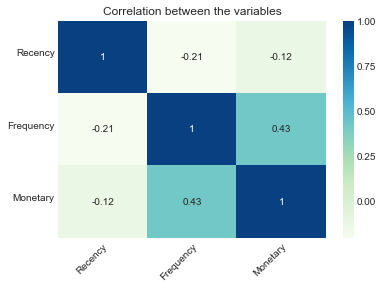

In [37]:
# plotting the correlation between the variables in a heatmap
fig, ax = plt.subplots()
sns.heatmap(corr, annot = True, cmap='GnBu')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.yticks(rotation=360, ha ='right', rotation_mode='anchor')
plt.title('Correlation between the variables')

The correlation between the variables is not very strong. There is a slight correlation between the monetary value and the frequency, indicating that to a certain extent, the more times a customer bought from the online store the higher the Monetary value. However I would have expected a stronger correlation between those two variables.

Next I will be looking at the distribution of the variables.

In [38]:
x= RFM_Data.set_index('CustomerID')


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

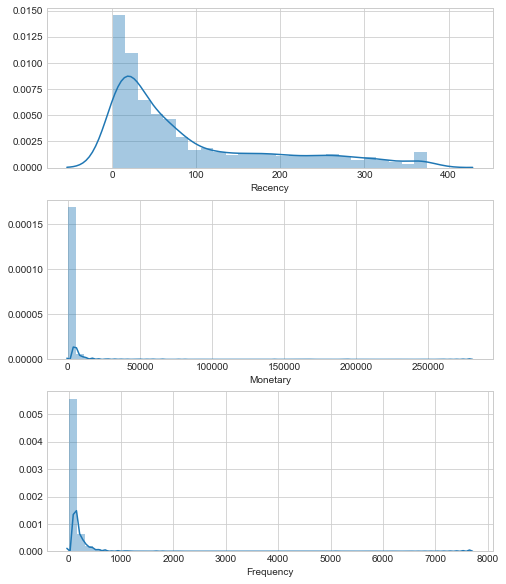

In [39]:
fig, ax = plt.subplots(3,1, figsize = (8,10))
sns.distplot(x['Recency'], label = 'Recency', ax=ax[0])
sns.distplot(x['Monetary'], label = 'Monetary', ax= ax[1])
sns.distplot(x['Frequency'], label = 'Frequency', ax = ax[2])
plt.tight_layout

From the above distribuitions we can see that the data is very heavily skewed especially for the Monetary and Frequency values. This is problematic as like a lot of statistical inferencing, Kmeans assumes the normality of variables. To unskew the data I will be applying a Log transformation to the columns.

In [40]:
x.describe()

,Recency,Frequency,Monetary
count,4339.000000,4339.000000,4339.000000
mean,92.518322,90.512100,2048.215924
std,100.009747,225.515328,8984.248352
min,1.000000,1.000000,0.000000
25%,18.000000,17.000000,306.455000
50%,51.000000,41.000000,668.560000
75%,142.000000,98.000000,1660.315000
max,374.000000,7676.000000,280206.020000


We can see from the above descriptive dataframe that the minimum value of the Monetary column is 0. The quantity Log(0) is undefined as there is no amount of times you can multiply 10 by itself and get 0. Therefore I will be excluding any 0 values for the Monetary column prior to the logarithmic transformation of the data.

In [41]:
x = x[x['Monetary']>0]
x.describe()

,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,92.536422,90.532734,2048.688081
std,100.014169,225.537229,8985.230220
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,306.482500
50%,51.000000,41.000000,668.570000
75%,142.000000,98.000000,1660.597500
max,374.000000,7676.000000,280206.020000


In [42]:
# Log transforming the data set
Log = np.log(x)
Log.describe()

,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,3.767534,3.671714,6.585704
std,1.432445,1.320661,1.261763
min,0.000000,0.000000,1.321756
25%,2.890372,2.833213,5.725161
50%,3.931826,3.713572,6.505141
75%,4.955827,4.584967,7.414933
max,5.924256,8.945854,12.543280


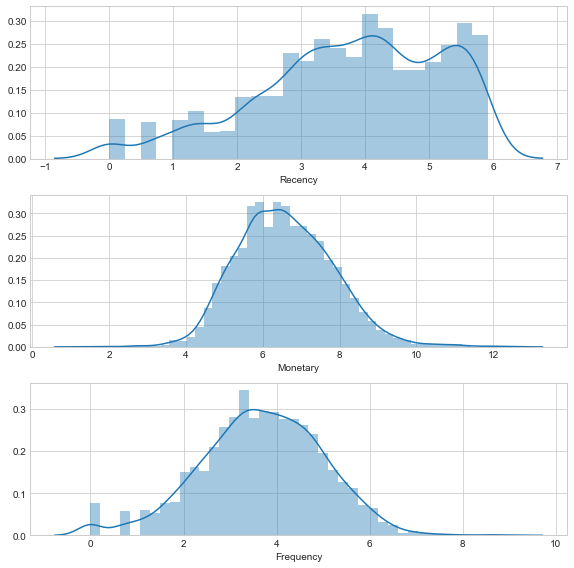

In [43]:
fig, ax = plt.subplots(3,1, figsize = (8,8))
sns.distplot(Log['Recency'], label = 'Recency', ax=ax[0])
sns.distplot(Log['Monetary'], label = 'Monetary', ax= ax[1])
sns.distplot(Log['Frequency'], label = 'Frequency', ax = ax[2])
plt.tight_layout()

The data is now much more normally distribuited and ready for further analysis. I have repeated the correlation test between variables. Logarithmic transformation of the columns has significantly improved the correlation of Frequency and Monetary from +0.43 to +0.76.

Text(0.5, 1.0, 'Correlation between the variables')

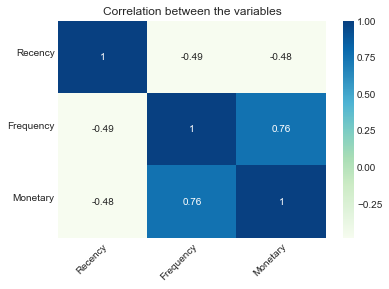

In [44]:
cor=Log[['Recency','Frequency','Monetary']].corr()
fig, ax = plt.subplots()
sns.heatmap(cor, annot = True, cmap='GnBu')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.yticks(rotation=360, ha ='right', rotation_mode='anchor')
plt.title('Correlation between the variables')

Text(0.5, 1.0, 'Relationship between Monetary and Frequency')

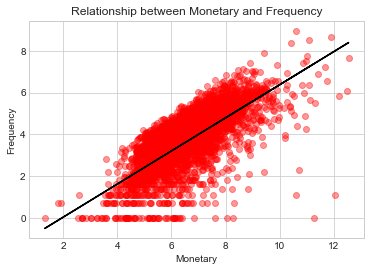

In [45]:
X,y = (Log['Monetary'].values[:,np.newaxis], Log['Frequency'].values)
model = LinearRegression()
model.fit(X,y)

plt.scatter(X, y, color='r', alpha = 0.4)
plt.plot(X, model.predict(X), color='k')
plt.xlabel('Monetary')
plt.ylabel('Frequency')
plt.title('Relationship between Monetary and Frequency')


After tranforming the data, the relationship between Monetary value and Frequency is increasingly similar to that which would be expected, such that the more often a customer makes purchases the higher their total monetary value.

Next, looking at the descriptive statistics above for the Log transformed data, we have different values for the Mean and Variance. This again violates another assumption of Kmeans which states that the variables must have the same average variables and the variables must have the same variance. Therefore we will be scaling the Log data using the StandardScaler algorithm.

In [46]:
scaled = StandardScaler().fit_transform(Log)
scaled

array([[ 1.40989446, -2.78052959,  3.70020082],
       [-2.14649825,  1.16038046,  1.41325634],
       [ 0.38397128, -0.18002665,  0.7199513 ],
       ...,
       [-1.17860486, -0.89875   , -1.11257171],
       [-1.66255156,  2.20288194,  0.82252182],
       [-0.00442205,  0.43678711,  0.73741623]])

### Clustering 

The data now conforms to the rules of clustering, however, I still do not know the number of clusters to use. To determine this the Elbow criterion is used. 

##### Elbow criterion

In the Elbow criterion the number of clusters is iterated and plotted against the within-cluster sum of squared error (Sum of squared distance from the data point to the cluster center).
From this plot, the point where the change in Error is significantly smaller than previous change in errors, refered to as the 'Elbow' is highlighted. This K value is then used as the ideal number of clusters.

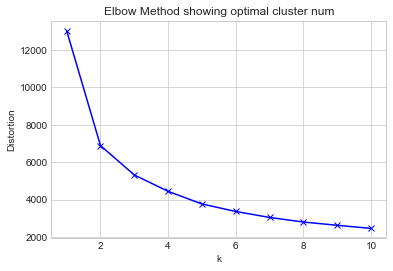

In [47]:
# setting up empty dictionary
distortion={}

#iterating k over a range of 1-10
K = range(1,11)

# Running Kmeans for the range of cluster centers
for k in K:
    kmeans =KMeans(n_clusters = k, random_state=111)
    kmeans.fit(scaled)
    distortion[k]=kmeans.inertia_
    
plt.plot(K, list(distortion.values()), 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method showing optimal cluster num')
plt.show()

From this, I can decipher that 3 is the optimal number of cluster centers. Therefore I will run the model at k=3.

In [48]:
#setting up the Kmeans model
Kmeans = KMeans(n_clusters = 3)
# Fitting the model to using the data
model = Kmeans.fit(scaled)
print('model\n', model)

model
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


The model has now been fitted to the dataset. I can now collect the assigned clusters and cluster centers for the data.

In [49]:
labels=Kmeans.predict(scaled)
centroids = Kmeans.cluster_centers_

In [50]:
labels, centroids

(array([2, 0, 2, ..., 1, 0, 2]),
 array([[-1.20143827,  1.13079775,  1.21150893],
        [ 0.72880902, -0.97726772, -0.92003331],
        [ 0.02159565,  0.21957663,  0.13067121]]))

Text(0.5, 0.92, 'Different customer clusters')

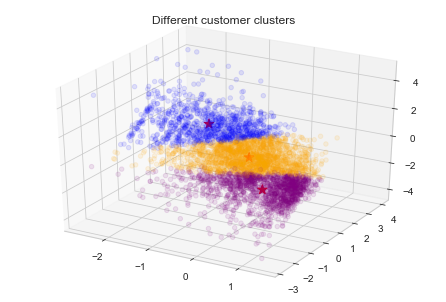

In [51]:
fig = plt.figure()
ax= Axes3D(fig)
colors=['blue','purple','orange']
ax.scatter(scaled[:,0], scaled[:,1], scaled[:, 2], c=labels, cmap= matplotlib.colors.ListedColormap(colors), alpha = 0.1)
ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], marker= '*', c='red', alpha = 1, s=100)
ax.set_title('Different customer clusters')

The above 3D graph accurately visualises the 3 clusters created by the cluster analysis. However, this does not help with creating labels for the data as I am unaware of the characteristics of the different clusters. To overcome this I will be plotting parallel line plots of the different  cluster centers.

The first step towards this is to merge the cluster prediction in a dataframe with the cluster centers.

In [52]:
# creating a list from the columns used for the analysis
colNames = list(x)
#adding 'prediction to the list'
colNames.append('prediction')

#iterating over the centroid array and counter and appending the counter to array to form labels
Z = [np.append(A, i) for i, A in enumerate(centroids,1)]
    
P = pd.DataFrame(Z, columns = colNames)
P['prediction'] = P['prediction'].astype(int)
P    

,Recency,Frequency,Monetary,prediction
0,-1.201438,1.130798,1.211509,1
1,0.728809,-0.977268,-0.920033,2
2,0.021596,0.219577,0.130671,3


To visualise the data in a way that allows me to analyse it, I will be plotting line plots of the cluster centres using parallel coordinates as mentioned earlier. I have decided to define a function for this so I can replicate the plot for different analyses.

In [53]:
#defining function name and input
def parallel_plot(Data):
    
    #cycle repeats the pattern 'b,r,g' infinitely and islice takes a slice the length of the data
    colours = list(islice(cycle(['b', 'r', 'g']), None, len(Data)))
    
    #setting figure and axes
    plt.figure(figsize = (15,8)).gca().axes.set_ylim([-2,+2])
    
    #setting the data and column to be plotted
    parallel_coordinates(Data, 'prediction', color = colours, marker ='o')

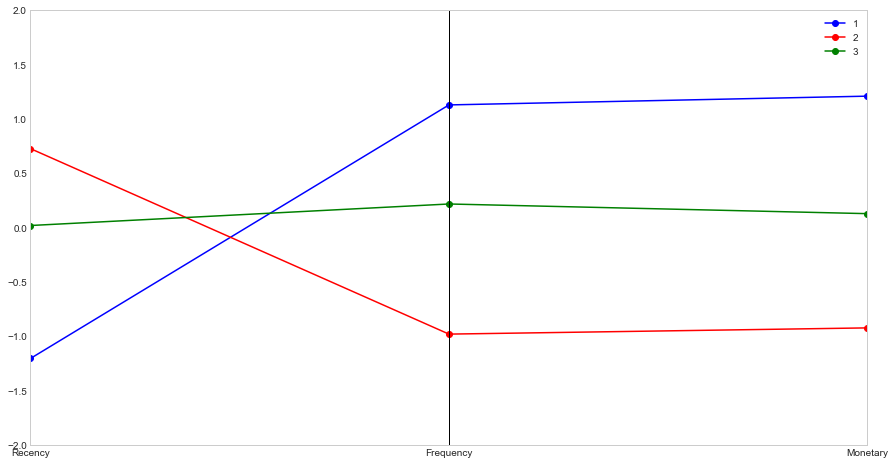

In [54]:
parallel_plot(P)

### To conclude..

We can see the 3 groups that have been created from the cluster analysis. 

* Group 1 will be called Recent Spenders due to their high recency, but low Frequency and Monetary value. This could be due to them being a new customer therefore, special unique incentives to convert them into loyal customers and increase their frequency should be considered.
* Group 2 will be called Almost lost. This group should be the most alarming to the Retail store. They have a high frequency and high Monetary value therefore, likely form a big chunk of the retailers income but they seem to have stopped buying from the online retail store. This could be due to them being lost to a competitor. Due to their value they will warrant more aggressive discounts to win them back before it's too late. 

* Group 3 will be called Loyal customers due to their average score across the columns. As the frequency is slightly higher than their monetary value in the scaled plot, the goal would be to provide them with the incentive to spend. Incentive includes offers with high hurdles that have to be cleared to gain rewards such as 'Buy 3 get 1 free'.
